In [1]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import functions as fn
import seaborn as sn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, roc_auc_score, plot_confusion_matrix, precision_score, recall_score, make_scorer
from sklearn.model_selection import GridSearchCV

In [2]:
#View options
#'display.float_format', lambda x: '%8.0f' % x
pd.set_option('display.max_columns', None, 'display.max_rows', None)

In [3]:
#Import final polished dataframe
df = pd.read_csv('data/final.csv',encoding='cp1252')

In [4]:
df = df.drop(columns=['Unnamed: 0'], axis=1)

In [5]:
df.shape

(73043, 23)

In [6]:
#Dealing with some missing school size data before transforming
df = df[df.Total_Students.apply(lambda x: x.isnumeric())]

In [7]:
#Transform all numerical data to appropriate datatypes
df['Total_Students'] = df['Total_Students'].astype(int)

In [8]:
#Found some nonsense values in Student/Teacher ratio column, need to replace with 16 (national average)
gibberish = df.loc[df['Student_Teacher_Ratio'] == 'Ã¢â‚¬â€œ']

In [9]:
df['level'] = np.nan

In [10]:
# Enumerate to replace values in ['Level'] to simplify variables
for i, element in enumerate(df['Level']): 
    if element == 'Secondary':
        df['level'][i] = 'High'
    elif element == 'Prekindergarten': 
        df['level'][i] = 'Other'
    elif element == 'Ungraded': 
        df['level'][i] = 'Other'
    elif element == 'Not applicable':
        df['level'][i] = 'Other' 
    else: 
        df['level'][i] = element

<ipython-input-10-3d3f8f40a880>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['level'][i] = element
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-10-3d3f8f40a880>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['level'][i] = 'High'
<ipython-input-10-3d3f8f40a880>:10: SettingWithCopy

In [11]:
df['level'].value_counts()

Elementary    40802
High          16289
Middle        13103
Other          2609
Name: level, dtype: int64

In [12]:
df = df.drop(['Level'], axis=1)

In [13]:
df = df.rename(columns={'level':'Level'})

In [14]:
#Need to fill Nans in Level column

In [15]:
df['Student_Teacher_Ratio'].replace('Ã¢â‚¬â€œ','16',inplace=True)

In [16]:
df = df[df['Student_Teacher_Ratio'] != 'Ã¢â‚¬Â']

In [17]:
df['Student_Teacher_Ratio'].replace('Ã¢â‚¬Â\xa0','16',inplace=True)

In [18]:
df['Student_Teacher_Ratio'] = df['Student_Teacher_Ratio'].astype(float)

In [19]:
# Exploring balance of target classes
df['Target'].value_counts(normalize=True)

0    0.506329
1    0.493671
Name: Target, dtype: float64

In [20]:
#Splitting data into features and target
#Dropping all identifier columns including zipcode - as median income is based on zipcode and is a good stand-in
target = df['Target']
features = df.drop(['School_ID','School_Name','District_Name','District_ID','Zip','City','Target'], axis=1)               

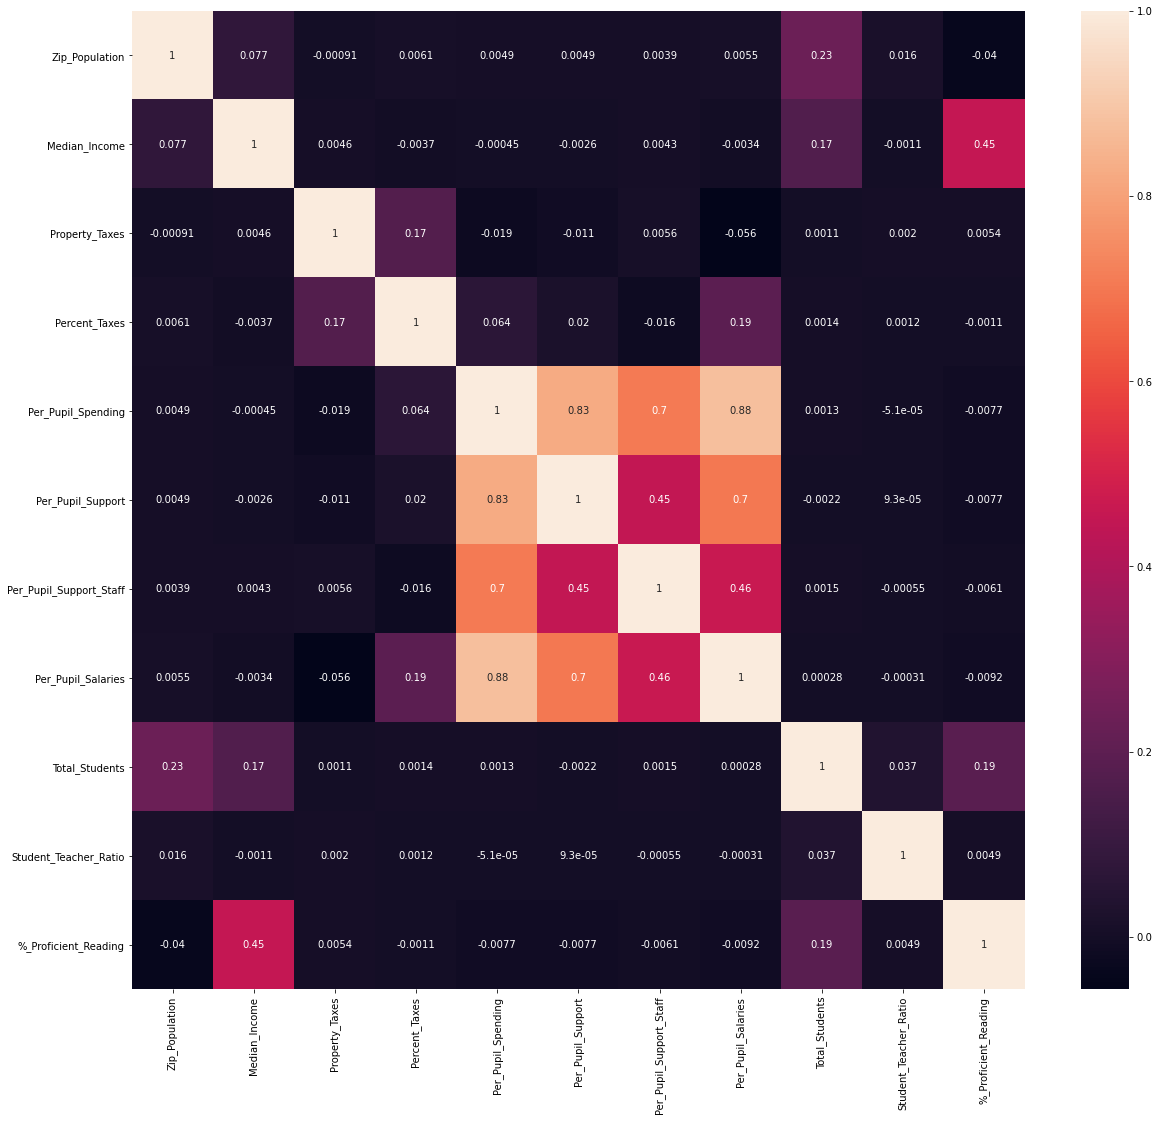

In [21]:
#Exploring multicollinearity
corr = features.corr()
pl.figure(figsize = (20,18))
sn.heatmap(corr, annot=True)
pl.show()

In [22]:
#Performing train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

### Dealing with Categorical Data

In [23]:
features.dtypes

State                       object
Zip_Population               int64
Density                     object
Median_Income                int64
Property_Taxes               int64
Percent_Taxes              float64
Per_Pupil_Spending           int64
Per_Pupil_Support            int64
Per_Pupil_Support_Staff      int64
Per_Pupil_Salaries           int64
Total_Students               int64
Student_Teacher_Ratio      float64
Title_I                     object
Virtual                     object
%_Proficient_Reading         int64
Level                       object
dtype: object

Since there are 50 state possibilities, one-hot encoding would lead to dozens of unnecessary columns. After some thought, I decided to use target encoding to deal with states, using the continuous version of the target to replace each state with the average percentage of students proficient in that state. Though this is an imperfect substitute for location, it is true that states differ markedly from each other in their levels of student achievement and tend to stay consistent from year to year (for example, Massachusetts is continually one of the top-performing states in the nation, while Louisiana is consistently one of the lowest). Thus, treating states this way should feed my model some valuable information about student performance.

In [24]:
#Target encoding state column 
#Create a groupby dataframe that gives us the mean in each numeric column for each state
state_averages = X_train.groupby(['State']).mean().reset_index()

In [25]:
state_averages = state_averages.filter(['%_Proficient_Reading','State'], axis=1).rename(columns={'%_Proficient_Reading':'State_Avg_Reading'})


In [26]:
#Join state helper dataframe with my training predictors and testing data
X_train = pd.merge(state_averages, X_train, how = 'inner', on='State').drop(['State','%_Proficient_Reading'], axis=1)
X_test = pd.merge(state_averages, X_test, how = 'inner', on='State').drop(['State','%_Proficient_Reading'], axis=1)

In [27]:
X_train.head()

,State_Avg_Reading,Zip_Population,Density,Median_Income,Property_Taxes,Percent_Taxes,Per_Pupil_Spending,Per_Pupil_Support,Per_Pupil_Support_Staff,Per_Pupil_Salaries,Total_Students,Student_Teacher_Ratio,Title_I,Virtual,Level
0,35.551829,107571,urban,64244,6090,41.4,9813,581,616,3995,321,12.07,yes,yes,Elementary
1,35.551829,3345,midsize,48462,1655,9.1,13105,676,209,4715,51,8.50,yes,yes,Middle
2,35.551829,11109,midsize,53209,136974,26.7,13167,932,800,5006,16,8.00,yes,yes,High
3,35.551829,273,midsize,43750,65265,68.9,14455,744,972,5637,14,6.36,yes,yes,High
4,35.551829,156504,urban,79706,251305,57.5,11650,730,496,4521,197,18.11,yes,yes,Elementary


In [28]:
#Deal with nulls in training and testing data
X_train = X_train.fillna(value = {"Level":"Other"})
X_test = X_test.fillna(value = {'Level':'Other'})

In [29]:
#Putting X back together
X = pd.concat([X_train, X_test], axis=0)

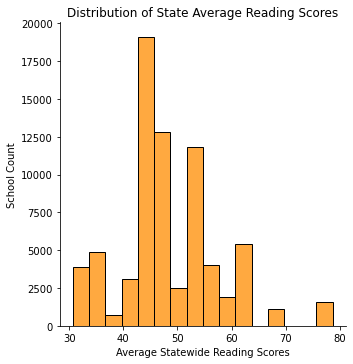

In [30]:
plot = sn.displot(X, x='State_Avg_Reading', binwidth=3, color="darkorange").set(title='Distribution of State Average Reading Scores')
x_axis = 'Average Statewide Reading Scores'
y_axis = 'School Count'
plot.set(xlabel = x_axis, ylabel=y_axis)
pl.savefig("State Averages Distribution")

In [31]:
#Now need to one-hot encode  categorical columns
#Isolate categorical columns
cats = X[['Density','Title_I', 'Virtual','Level']]
#Transform data
cats = pd.get_dummies(cats)

In [32]:
cats.head()

,Density_midsize,Density_urban,Title_I_no,Title_I_yes,Virtual_no,Virtual_yes,Level_Elementary,Level_High,Level_Middle,Level_Other
0,0,1,0,1,0,1,1,0,0,0
1,1,0,0,1,0,1,0,0,1,0
2,1,0,0,1,0,1,0,1,0,0
3,1,0,0,1,0,1,0,1,0,0
4,0,1,0,1,0,1,1,0,0,0


In [33]:
cats.to_csv('data/categorical_data')

In [34]:
#Merge with main dataframe on key values
X_numeric = pd.concat([X, cats], axis=1)

In [35]:
X_numeric.head()

,State_Avg_Reading,Zip_Population,Density,Median_Income,Property_Taxes,Percent_Taxes,Per_Pupil_Spending,Per_Pupil_Support,Per_Pupil_Support_Staff,Per_Pupil_Salaries,Total_Students,Student_Teacher_Ratio,Title_I,Virtual,Level,Density_midsize,Density_urban,Title_I_no,Title_I_yes,Virtual_no,Virtual_yes,Level_Elementary,Level_High,Level_Middle,Level_Other
0,35.551829,107571,urban,64244,6090,41.4,9813,581,616,3995,321,12.07,yes,yes,Elementary,0,1,0,1,0,1,1,0,0,0
1,35.551829,3345,midsize,48462,1655,9.1,13105,676,209,4715,51,8.50,yes,yes,Middle,1,0,0,1,0,1,0,0,1,0
2,35.551829,11109,midsize,53209,136974,26.7,13167,932,800,5006,16,8.00,yes,yes,High,1,0,0,1,0,1,0,1,0,0
3,35.551829,273,midsize,43750,65265,68.9,14455,744,972,5637,14,6.36,yes,yes,High,1,0,0,1,0,1,0,1,0,0
4,35.551829,156504,urban,79706,251305,57.5,11650,730,496,4521,197,18.11,yes,yes,Elementary,0,1,0,1,0,1,1,0,0,0


In [36]:
#Drop non-numeric categorical columns 
X_numeric = X_numeric.drop(['Density','Title_I', 'Virtual','Level'], axis=1)

In [37]:
X_numeric.head()

,State_Avg_Reading,Zip_Population,Median_Income,Property_Taxes,Percent_Taxes,Per_Pupil_Spending,Per_Pupil_Support,Per_Pupil_Support_Staff,Per_Pupil_Salaries,Total_Students,Student_Teacher_Ratio,Density_midsize,Density_urban,Title_I_no,Title_I_yes,Virtual_no,Virtual_yes,Level_Elementary,Level_High,Level_Middle,Level_Other
0,35.551829,107571,64244,6090,41.4,9813,581,616,3995,321,12.07,0,1,0,1,0,1,1,0,0,0
1,35.551829,3345,48462,1655,9.1,13105,676,209,4715,51,8.50,1,0,0,1,0,1,0,0,1,0
2,35.551829,11109,53209,136974,26.7,13167,932,800,5006,16,8.00,1,0,0,1,0,1,0,1,0,0
3,35.551829,273,43750,65265,68.9,14455,744,972,5637,14,6.36,1,0,0,1,0,1,0,1,0,0
4,35.551829,156504,79706,251305,57.5,11650,730,496,4521,197,18.11,0,1,0,1,0,1,1,0,0,0


In [38]:
#Have to re-do the train test split
X_train, X_test, y_train, y_test = train_test_split(X_numeric, target, test_size=0.20, random_state=42)

### Scaling Data

In [39]:
scaler = StandardScaler()
# Train our scaler on training data, then fit to testing
X_train_scaled = scaler.fit_transform(X_train, y=None)
X_test_scaled = scaler.transform(X_test)

### Baseline Modeling

Schools with below 50% proficiency) comprise the majority class. Could a baseline model do better than that?  

In [40]:
train = X_train.copy()
train['target'] = y_train.values

In [41]:
test = X_test
test['target'] = y_test

<ipython-input-41-fd87e67f2ec4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['target'] = y_test


In [42]:
len(train) + len(test)

72923

In [43]:
# Make baseline dataframe 
bdf = pd.concat([train,test],axis=0)

In [44]:
# Number correct is number of proficient districts with state proficiency > 50%
# and non-proficient districts with state proficiency < 50%.
prof_correct = len(bdf[(bdf['State_Avg_Reading']>50) & (bdf['target']==1)])
notprof_correct = len(bdf[(bdf['State_Avg_Reading']<50) & (bdf['target']==0)])

# Add totals
correct = prof_correct + notprof_correct
print(f'Baseline accuracy based on average statewide reading proficiency: {correct/len(bdf):.2}')

Baseline accuracy based on average statewide reading proficiency: 0.42


So a model that predicts a district's reading proficiency based on the overall average proficiency for the state in which the school is located only predicts correctly 42% of the time. We're better off just randomly guessing that a district is proficient!

### Logistic Regression Model

In [45]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [46]:
logreg.score(X_train_scaled, y_train)

0.49958860434022423

In [47]:
logreg.score(X_test_scaled, y_test)

0.49948577305450803

First logistic regression model did slightly better than baseline model, but still worse than randomly guessing the majority class. Hopefully our other classifier models can perform better. 

### K-Nearest Neighbors Model

In [48]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)
#Predictions for the testing set
y_preds = knn.predict(X_test_scaled)

In [49]:
#fn.evaluate(knn, X_train_scaled, X_test_scaled, y_train, y_test)

Overfitting appears to be a significant problem; training data does OK but precision score drops a ton on testing. Before turning to feature engineering or a grid search, I'm going to try a couple of other models to see how well they perform comparatively. 

### Random Forest Model

In [50]:
rf = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=0)
rf.fit(X_train_scaled, y_train)
rf_preds = rf.predict(X_test_scaled) 

Train Scores
------------
Accuracy: 0.5462134457814803
Precision: 0.5572052350996511
F1 Score: 0.388487214432561
ROC-AUC: 0.5729902315253592
--------------------
Test Scores
-----------
Accuracy: 0.5099760027425437
Precision: 0.5094854421392278
F1 Score: 0.3425627817128139
ROC-AUC: 0.5171724930183379


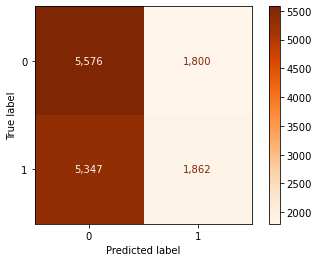

In [51]:
fn.evaluate(rf, X_train_scaled, X_test_scaled, y_train, y_test)

This has reduced overfitting somewhat, but precision has stayed mostly the same and is still about as accurate as random guessing.

### Gradient Boosting Model

In [52]:
#Trying sklearn gradient boosting instead
gbmodel = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
max_depth=1, random_state=0).fit(X_train_scaled, y_train)

In [53]:
gbmodel_preds = gbmodel.predict(X_test_scaled)

Train Scores
------------
Accuracy: 0.5302547224793445
Precision: 0.5302896143154076
F1 Score: 0.4684820978315683
ROC-AUC: 0.5416854063586019
--------------------
Test Scores
-----------
Accuracy: 0.5088789852588276
Precision: 0.5081152843338089
F1 Score: 0.4521606118546845
ROC-AUC: 0.5146425243782702


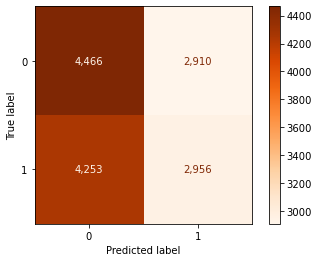

In [54]:
fn.evaluate(gbmodel, X_train_scaled, X_test_scaled, y_train, y_test)

Using gradient boosting did not appear to have any discernible improvement for my model. However, the gap in precision scores between training and testing models was the smallest here out of any of the three algorithms.

### AdaBoost Classifier

In [55]:
ada = AdaBoostClassifier()
ada.fit(X_train_scaled, y_train)

AdaBoostClassifier()

Train Scores
------------
Accuracy: 0.5256265213068669
Precision: 0.5256298677591841
F1 Score: 0.4527585525014831
ROC-AUC: 0.5348502262364381
--------------------
Test Scores
-----------
Accuracy: 0.5141583818992115
Precision: 0.5135882393848866
F1 Score: 0.4478728377746611
ROC-AUC: 0.5149032083299107


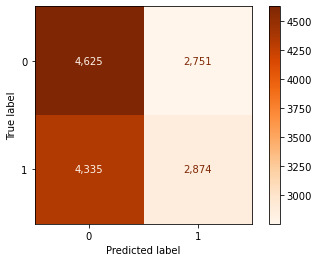

In [56]:
fn.evaluate(ada, X_train_scaled, X_test_scaled, y_train, y_test)

### Feature Engineering and Model Improvement

In [57]:
importances = rf.feature_importances_

In [58]:
feature_names = X_test.drop(labels='target', axis=1)

In [59]:
rf_importances = pd.DataFrame(index=feature_names.columns, data=importances).sort_values(by=0,ascending=False)

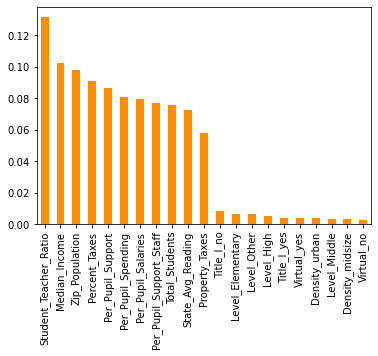

In [60]:
# plot feature importance
rf_importances.plot(kind='bar', legend=False, color='darkorange');
pl.savefig('Initial Feature Importances')

As a first try, I'm going to select only the top eight features with an importance of over .06 and rerun the models to see if these improve precision scores. As an added bonus, this feature selection might make my models more interpretable. Since my gradient boosting model seemed the most effective when it came to minimizing overfitting, I will re-run this algorithm on my new features.

In [61]:
top8_X_numeric = X_numeric[['Student_Teacher_Ratio','Median_Income','Zip_Population','Per_Pupil_Salaries','Per_Pupil_Support','Total_Students','Per_Pupil_Spending','Percent_Taxes']]



In [62]:
#Have to re-do the train test split
top8_X_train, top8_X_test, y_train, y_test = train_test_split(X_numeric, target, test_size=0.20, random_state=42)

In [63]:
#Scale the data again
top8_X_train_scaled = scaler.fit_transform(top8_X_train, y=None)
top8_X_test_scaled = scaler.transform(top8_X_test)

In [64]:
#Run Gradient Boosting 
top8_gbmodel = GradientBoostingClassifier(n_estimators=100,
max_depth=1, random_state=0).fit(top8_X_train_scaled, y_train)

In [65]:
top8_gbmodel_preds = top8_gbmodel.predict(top8_X_test_scaled)

Train Scores
------------
Accuracy: 0.5154273372415921
Precision: 0.5169005439796527
F1 Score: 0.32755298651252407
ROC-AUC: 0.5234222677002526
--------------------
Test Scores
-----------
Accuracy: 0.5090846760370243
Precision: 0.5084717822395158
F1 Score: 0.3223547226954382
ROC-AUC: 0.5144109150137406


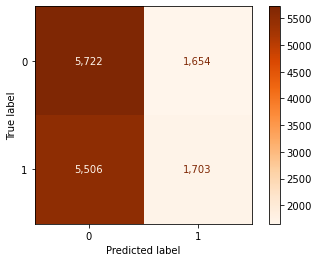

In [66]:
fn.evaluate(top8_gbmodel, top8_X_train_scaled, top8_X_test_scaled, y_train, y_test)

Selecting features had no discernible effect on my model. Going to try tuning some of the more important hyperparameters next, such as learning rate.

In [67]:
X_numeric.shape

(72923, 21)

In [68]:
#Seeing how models performs with default parameters
default = GradientBoostingClassifier().fit(top8_X_train_scaled, y_train)

In [69]:
default_preds = default.predict(top8_X_test_scaled)

Train Scores
------------
Accuracy: 0.552795776337893
Precision: 0.5559542402964572
F1 Score: 0.4676257524742373
ROC-AUC: 0.5812463785107822
--------------------
Test Scores
-----------
Accuracy: 0.5113472745971889
Precision: 0.5106057777128289
F1 Score: 0.4260288314407667
ROC-AUC: 0.5152472137292834


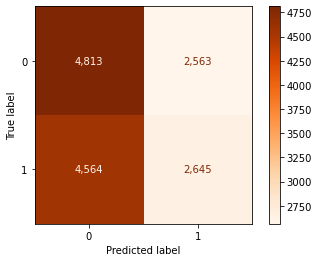

In [70]:
fn.evaluate(default, top8_X_train_scaled, top8_X_test_scaled, y_train, y_test)


With default parameters, precision score went up slightly (by .02%); however, overfitting also worsened slightly. Going to try a GridSearch CV next. 

loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0

In [71]:
X_numeric.shape

(72923, 21)

**min_samples_split = 700**: min_samples should be ~.05 - 1% of total values. Since this is a balanced class problem, will take towards the larger end of the range. 1% of 72920 is about 700.

**max_depth = 7**: Should be chosen (5-8) based on the number of observations and predictors. This has 72K rows and 21 columns so lets take 7 here.

**max_features = sqrt**: Rule of thumb.

**subsample == 0.8**: Commonly used start value.

In [72]:
#Creating scoring parameter: 
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),'recall':make_scorer(recall_score)}

# A sample parameter
parameters = {
    "min_samples_split": [100],
    "max_depth":[7],
    "max_features":["sqrt"],
    "subsample":[0.8],
    "n_estimators":range(20,81,10)
    }
#Passing the scoring function in the GridSearchCV
clf = GridSearchCV(GradientBoostingClassifier(), parameters,scoring=scoring,refit=False,cv=2, n_jobs=-1)

clf.fit(top8_X_train_scaled, y_train)
#Converting the clf.cv_results to dataframe
results=pd.DataFrame.from_dict(clf.cv_results_)
#Here are inputs for cross validation is cv=2, there two split split0 and split1
results[['split0_test_accuracy','split1_test_accuracy','split0_test_precision','split1_test_precision','split0_test_recall','split1_test_recall']]

,split0_test_accuracy,split1_test_accuracy,split0_test_precision,split1_test_precision,split0_test_recall,split1_test_recall
0,0.505160,0.505194,0.498302,0.498299,0.387260,0.386662
1,0.502828,0.505708,0.495670,0.499065,0.421437,0.426398
2,0.504782,0.505297,0.498020,0.498606,0.428036,0.434873
3,0.504474,0.505057,0.497662,0.498361,0.428869,0.443557
4,0.503720,0.501663,0.496872,0.494318,0.441303,0.426051
5,0.504200,0.503994,0.497433,0.497179,0.444221,0.446822
6,0.498337,0.503308,0.490944,0.496496,0.446235,0.457728


In [73]:
#find the best parameter based on the accuracy_score
#taking the average of the precision
results['precision_score']=(results['split0_test_precision']+results['split1_test_precision'])/2

results.loc[results['precision_score'].idxmax()]['params']

{'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_split': 100,
 'n_estimators': 40,
 'subsample': 0.8}

### Adding More Data

Since the gridsearches did not work to improve the model's performance significantly, I'm going to try adding in some additional features to the model to see if that improves the score.

In [74]:
money = pd.read_csv('data/sdf19_1a.txt',sep="\t")

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (0,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [75]:
money.shape

(19700, 262)

In [76]:
df['District_ID'] = df['District_ID'].astype(str)

In [77]:
addtl_features = money[['LEAID','TOTALREV','TFEDREV','TSTREV','TLOCREV','T40','Z32','Z33']]

In [78]:
addtl_features = addtl_features.rename({'LEAID':'District_ID', 'TOTALREV':'Total_Revenue','TFEDREV':'Federal_Revenue','TSTREV':'State_Revenue','TLOCREV':'Local_Revenue','T40':'Income_Taxes','Z32':'Total_Salaries','Z33':'Instructional_Salaries'
                                       },axis=1)

In [79]:
df2 = df.merge(addtl_features, on='District_ID', how='inner')

In [80]:
df2.head()

,School_ID,School_Name,District_Name,District_ID,City,State,Zip,Zip_Population,Density,Median_Income,Property_Taxes,Percent_Taxes,Per_Pupil_Spending,Per_Pupil_Support,Per_Pupil_Support_Staff,Per_Pupil_Salaries,Total_Students,Student_Teacher_Ratio,Title_I,Virtual,%_Proficient_Reading,Target,Level,Total_Revenue,Federal_Revenue,State_Revenue,Local_Revenue,Income_Taxes,Total_Salaries,Instructional_Salaries
0,NC-32M-000,Global Scholars Academy,AUTAUGA COUNTY SCHOOL DISTRICT,3700316,Durham,NC,27701,63864,midsize,41566,7637,8.7,8600,512,241,3357,206,11.31,yes,no,30,0,Elementary,2855000,320000,1506000,1029000,-2,1875000,1165000
1,NC-320-310,Eastway Elementary,LOS ANGELES UNIF SCH DIST,3701260,Durham,NC,27701,63864,midsize,41566,2411346,24.4,15793,969,1189,5023,439,11.31,yes,no,11,0,Elementary,413911000,45699000,213378000,154834000,-2,247872000,166724000
2,NC-320-347,George Watts Elementary,WHITTIER CY SCHOOL DISTRICT,3701260,Durham,NC,27701,63864,midsize,41566,15097,18.2,12453,588,825,4813,363,11.86,yes,no,55,1,Elementary,413911000,45699000,213378000,154834000,-2,247872000,166724000
3,NC-320-323,Durham School of the Arts,CHARLES CO SCHS,3701260,Durham,NC,27701,63864,midsize,41566,0,46.0,14732,786,738,5595,1869,16.78,yes,yes,68,1,High,413911000,45699000,213378000,154834000,-2,247872000,166724000
4,NC-320-308,Burton Elementary,DANIEL MORGAN AREA VOCATIONAL CENTER,3701260,Durham,NC,27701,63864,midsize,41566,0,0.0,0,0,0,0,339,10.59,yes,no,40,0,Elementary,413911000,45699000,213378000,154834000,-2,247872000,166724000


### Transforming Dataframe with Additional Features 

In [81]:
#Splitting data into features and target
#Dropping all identifier columns including zipcode - as median income is based on zipcode and is a good stand-in
target2 = df2['Target']
features2 = df2.drop(['School_ID','School_Name','District_Name','District_ID','Zip','City','Target'], axis=1)               

In [82]:
#Performing train-test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(features2, target2, test_size=0.20, random_state=42)

In [83]:
#Join state helper dataframe with my training predictors and testing data
X_train2 = pd.merge(state_averages, X_train2, how = 'inner', on='State').drop(['State','%_Proficient_Reading'], axis=1)
X_test2 = pd.merge(state_averages, X_test2, how = 'inner', on='State').drop(['State','%_Proficient_Reading'], axis=1)

In [84]:
X_train2.head()

,State_Avg_Reading,Zip_Population,Density,Median_Income,Property_Taxes,Percent_Taxes,Per_Pupil_Spending,Per_Pupil_Support,Per_Pupil_Support_Staff,Per_Pupil_Salaries,Total_Students,Student_Teacher_Ratio,Title_I,Virtual,Level,Total_Revenue,Federal_Revenue,State_Revenue,Local_Revenue,Income_Taxes,Total_Salaries,Instructional_Salaries
0,31.931034,45996,midsize,167375,989357,47.9,10173,392,1145,3257,902,13.56,no,no,Elementary,1526358000,132899000,0,1393459000,-2,753686000,431471000
1,31.931034,157110,urban,90424,231098,19.2,13175,687,696,4720,399,12.00,yes,no,Elementary,1526358000,132899000,0,1393459000,-2,753686000,431471000
2,31.931034,34530,midsize,84484,3595,27.2,10928,340,395,5608,229,13.47,yes,no,Elementary,5614000,399000,0,5215000,-2,2390000,1487000
3,31.931034,50682,midsize,67279,6380,16.6,9999,906,594,3395,234,10.58,yes,no,Elementary,103320000,9720000,0,93600000,-2,52235000,31065000
4,31.931034,175608,urban,77931,142245,50.4,9183,531,534,4448,517,10.77,yes,no,Elementary,1526358000,132899000,0,1393459000,-2,753686000,431471000


In [85]:
#Deal with nulls in training and testing data
X_train2 = X_train2.fillna(value = {"Level":"Other"})
X_test2 = X_test2.fillna(value = {'Level':'Other'})

In [86]:
#Putting X back together
X2 = pd.concat([X_train2, X_test2], axis=0)

In [87]:
#Now need to one-hot encode  categorical columns
#Isolate categorical columns
cats2 = X2[['Density','Title_I', 'Virtual','Level']]
#Transform data
cats2 = pd.get_dummies(cats2)

In [88]:
#Merge with main dataframe on key values
X_numeric2 = pd.concat([X2, cats2], axis=1)

In [89]:
#Drop non-numeric categorical columns 
X_numeric2 = X_numeric2.drop(['Density','Title_I', 'Virtual','Level'], axis=1)

In [90]:
#Have to re-do the train test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_numeric2, target2, test_size=0.20, random_state=42)

### Scaling Data Again

In [91]:
scaler = StandardScaler()
# Train our scaler on training data, then fit to testing
X_train_scaled2 = scaler.fit_transform(X_train2, y=None)
X_test_scaled2 = scaler.transform(X_test2)

### Logistic Regression Model with Additional Features

In [92]:
logreg = LogisticRegression()
logreg.fit(X_train2, y_train2)

LogisticRegression()

In [93]:
logreg.score(X_train_scaled2, y_train2)

0.5112719039180941

In [94]:
logreg.score(X_test_scaled2, y_test2)

0.5143700787401575

### KNN Model with Additional Features

In [95]:
knn2 = KNeighborsClassifier(n_neighbors=3)
knn2.fit(X_train_scaled2, y_train2)
#Predictions for the testing set
y_preds = knn2.predict(X_test_scaled2)

In [96]:
#fn.evaluate(knn2, X_train_scaled2, X_test_scaled2, y_train2, y_test2)

### Random Forest Model with Additional Features

In [97]:
rf2 = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=0)
rf2.fit(X_train_scaled2, y_train2)
rf_preds2 = rf2.predict(X_test_scaled2) 

Train Scores
------------
Accuracy: 0.5567532978932861
Precision: 0.5922836369167271
F1 Score: 0.2589087317916221
ROC-AUC: 0.603876244554181
--------------------
Test Scores
-----------
Accuracy: 0.5311023622047244
Precision: 0.5307999018180948
F1 Score: 0.21799080761654632
ROC-AUC: 0.5335014447275213


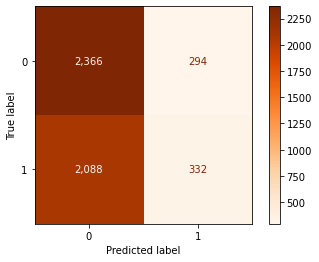

In [98]:
fn.evaluate(rf2, X_train_scaled2, X_test_scaled2, y_train2, y_test2)

### Gradient Boosting Model with Additional Features

In [99]:
gbmodel2 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
max_depth=1, random_state=0).fit(X_train_scaled2, y_train2)

In [100]:
gbmodel_preds2 = gbmodel2.predict(X_test_scaled2)

Train Scores
------------
Accuracy: 0.5568517424689899
Precision: 0.5563906065602169
F1 Score: 0.44215874589503684
ROC-AUC: 0.5817307743193432
--------------------
Test Scores
-----------
Accuracy: 0.5246062992125984
Precision: 0.5191909489014496
F1 Score: 0.39970171513795677
ROC-AUC: 0.5289487665444603


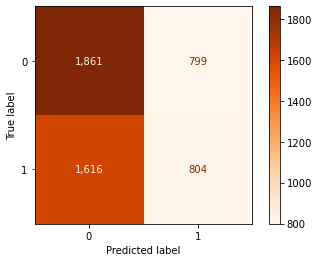

In [101]:
fn.evaluate(gbmodel2, X_train_scaled2, X_test_scaled2, y_train2, y_test2)

### AdaBoost Model with Additional Features

In [102]:
ada2 = AdaBoostClassifier()
ada2.fit(X_train_scaled2, y_train2)

AdaBoostClassifier()

Train Scores
------------
Accuracy: 0.5481886198070486
Precision: 0.5473534302417666
F1 Score: 0.4113384210863849
ROC-AUC: 0.5665012367094673
--------------------
Test Scores
-----------
Accuracy: 0.5330708661417323
Precision: 0.5286676185995957
F1 Score: 0.39117043121149897
ROC-AUC: 0.5327304573417013


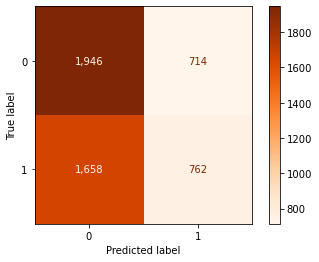

In [103]:
fn.evaluate(ada2, X_train_scaled2, X_test_scaled2, y_train2, y_test2)

### Feature Importances with Additional Features

In [104]:
importances2 = rf2.feature_importances_

In [105]:
rf_importances2 = pd.DataFrame(index=X_test2.columns, data=importances2).sort_values(by=0,ascending=False)

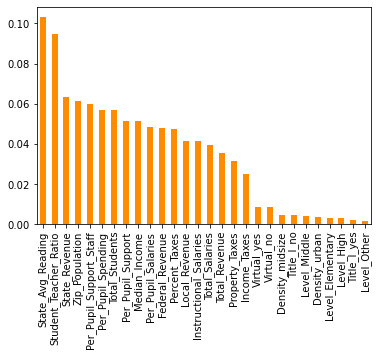

In [106]:
# plot feature importance
rf_importances2.plot(kind='bar', legend=False, color='darkorange');

### Logistic Regression Model Tuning

In [107]:
# Perform GridSearchCV to tune best-fit LR model
param = {'C': [10**-2,10**-1,10**0,10**1,10**2]}

lr_model3 = LogisticRegression(penalty='l1', solver='liblinear')
gs_model = GridSearchCV(estimator=lr_model3, param_grid=param)
gs_model.fit(X_train_scaled2, y_train2)

# Train a LR model with best parameters
model3 = LogisticRegression(**gs_model.best_params_, penalty='l1', solver='liblinear')
model3.fit(X_train_scaled2, y_train2)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [108]:
model3.score(X_train_scaled2, y_train2)

0.526776924591455

In [109]:
logreg.score(X_test_scaled2, y_test2)

0.5143700787401575

In [110]:
coef = model3.coef_[0]
coef

array([ 2.67298852e-02, -1.62407796e-03,  9.58910771e-03, -1.52679611e-02,
        1.02067712e-02, -6.79557743e-03,  1.09227791e-02,  0.00000000e+00,
       -1.99618446e-03, -2.25262777e-02, -1.19730073e-02,  0.00000000e+00,
       -7.61796881e-02,  7.45956195e-02, -1.79029744e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.03859221e-02, -4.58705693e-04,
        1.81287795e-03, -1.94485770e-03, -3.63177088e-02,  3.41608791e-07,
       -5.33457132e-04,  0.00000000e+00,  2.62187646e-03, -6.91108267e-03])

In [111]:
coef = model3.coef_[0]
imp_features = pd.Series(X_test2.columns)[list(coef!=0)]
X_train3 = X_train2[imp_features]
X_test3 = X_test2[imp_features]

In [112]:
print('Redundant Feature Names:', list(pd.Series(X_test2.columns[list(coef==0)])))

Redundant Feature Names: ['Per_Pupil_Support_Staff', 'Total_Revenue', 'Income_Taxes', 'Total_Salaries', 'Instructional_Salaries', 'Level_High']


In [113]:
# Trying logistic regression model without redundant features
X_train_scaled3 = scaler.fit_transform(X_train2, y=None)
X_test_scaled3 = scaler.transform(X_test2)

In [114]:
logreg3 = LogisticRegression()
logreg3.fit(X_train_scaled3, y_train2)

LogisticRegression()

In [115]:
logreg.score(X_train_scaled3, y_train2)

0.5112719039180941

In [116]:
logreg.score(X_test_scaled3, y_test2)

0.5143700787401575

### Adding Even More Data

Since I'm not having a lot of luck with adding just a handful of features that I think are the most important, I'm going to add in all of the financial data I currently have to see if that improves my model. 

In [117]:
money.head()

,LEAID,CENSUSID,FIPST,CONUM,CSA,CBSA,NAME,STNAME,STABBR,SCHLEV,AGCHRT,YEAR,CCDNF,CENFILE,GSLO,GSHI,V33,MEMBERSCH,TOTALREV,TFEDREV,C14,C15,C16,C17,C19,B11,C20,C25,C36,B10,B12,B13,TSTREV,C01,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C35,C38,C39,TLOCREV,T02,T06,T09,T15,T40,T99,D11,D23,A07,A08,A09,A11,A13,A15,A20,A40,U11,U22,U30,U50,U97,C24,TOTALEXP,TCURELSC,TCURINST,E13,V91,V92,TCURSSVC,E17,E07,E08,E09,V40,V45,V90,V85,TCUROTH,E11,V60,V65,TNONELSE,V70,V75,V80,TCAPOUT,F12,G15,K09,K10,K11,L12,M12,Q11,I86,Z32,Z33,Z35,Z36,Z37,Z38,V11,V13,V15,V17,V21,V23,V37,V29,Z34,V10,V12,V14,V16,V18,V22,V24,V38,V30,V32,V93,_19H,_21F,_31F,_41F,_61V,_66V,W01,W31,W61,V95,V02,K14,CE1,CE2,CE3,WEIGHT,FL_V33,FL_MEMBERSCH,FL_C14,FL_C15,FL_C16,FL_C17,FL_C19,FL_B11,FL_C20,FL_C25,FL_C36,FL_B10,FL_B12,FL_B13,FL_C01,FL_C04,FL_C05,FL_C06,FL_C07,FL_C08,FL_C09,FL_C10,FL_C11,FL_C12,FL_C13,FL_C35,FL_C38,FL_C39,FL_T02,FL_T06,FL_T09,FL_T15,FL_T40,FL_T99,FL_D11,FL_D23,FL_A07,FL_A08,FL_A09,FL_A11,FL_A13,FL_A15,FL_A20,FL_A40,FL_U11,FL_U22,FL_U30,FL_U50,FL_U97,FL_C24,FL_E13,FL_V91,FL_V92,FL_E17,FL_E07,FL_E08,FL_E09,FL_V40,FL_V45,FL_V90,FL_V85,FL_E11,FL_V60,FL_V65,FL_V70,FL_V75,FL_V80,FL_F12,FL_G15,FL_K09,FL_K10,FL_K11,FL_L12,FL_M12,FL_Q11,FL_I86,FL_Z32,FL_Z33,FL_Z35,FL_Z36,FL_Z37,FL_Z38,FL_V11,FL_V13,FL_V15,FL_V17,FL_V21,FL_V23,FL_V37,FL_V29,FL_Z34,FL_V10,FL_V12,FL_V14,FL_V16,FL_V18,FL_V22,FL_V24,FL_V38,FL_V30,FL_V32,FL_V93,FL_19H,FL_21F,FL_31F,FL_41F,FL_61V,FL_66V,FL_W01,FL_W31,FL_W61,FL_V95,FL_V02,FL_K14,FL_CE1,FL_CE2,FL_CE3
0,100002,N,1,1073,142,13820,Alabama Youth Services,Alabama,AL,N,N,19,1,0,03,12,-2,-2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-2,-2,-2,-2,-2,-2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,N,N,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,N,N,N,N,N,N,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M
1,100005,01504840100000,1,1095,290,10700,Albertville City,Alabama,AL,03,3,19,1,1,PK,12,5636,5636,60116000,7939000,2439000,1134000,240000,0,101000,103000,412000,3467000,0,0,0,43000,36177000,29411000,78000,0,293000,97000,0,0,0,1555000,2275000,2468000,0,0,0,16000000,-2,5787000,0,0,0,430000,17000,5400000,93000,0,232000,0,1631000,0,366000,122000,78000,345000,2000,131000,1366000,0,55237000,49715000,28612000,28612000,0,0,17262000,3619000,1453000,1470000,2652000,4401000,2796000,871000,0,3841000,3841000,0,0,949000,150000,198000,601000,2750000,2351000,0,120000,279000,0,0,0,86000,1737000,26349000,16897000,13210000,838000,1089000,505000,2091000,794000,752000,1842000,1014000,1308000,530000,929000,10588000,6508000,780000,293000,219000,686000,458000,878000,163000,555000,0,395000,28876000,2017000,2634000,28259000,0,0,9516000,738000,8987000,1085000,0,0,-1,-1,0,1,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,M,M,M,R,R,R,R,M,M,N,R,M,M,M,R,R,R,R,M,R,R,R,R,R,R,R,R,R,R,R,R,R,R,M,R,R,R,R,R,R,R,R,R,M,M,R,R,R,R,R,R,R,R,M,M,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,R,M,R,A,R,R,I,M,M,R,R,R,R,M,M,M,M,M
2,100006,01504800100000,1,1095,290,10700,Marshall County,Alabama,AL,03,3,19,1,1,PK,12,5652,5652,61936000,7953000,2758000,1465000,386000,0,145000,51000,331000,2817000,0,0,0,0,40042000,30760000,65000,0,552000,42000,0,0,0,1642000,3434000,3547000,0,0,0,13941000,-2,7162000,0,0,0,10000,0,2054000,14000,0,575000,0,1495000,0,324000,1000,489000,209000,5000,535000,1068000,0,60022000,58351000,30884000,30884000,7000,0,23015000,4095000,1849000,2074000,3902000,5986000,3929000,1180000,0,4452000,4452000,0,0,724000,64000,167000,493000,266000,0,48000,65000,153000,0,0,0,48000,626000,32647000,19574000,13204000,1913000,1277000,772000,2618000,909000,1105000,2727000,1636000,2057000,508000,1370000,13208000,7529000,942000

In [118]:
cols = [c for c in money.columns if c.lower()[:2] != 'fl']

In [119]:
money = money[cols]

In [120]:
money_nums = money.drop(labels=['CENSUSID','CONUM','CSA','CBSA','NAME','STNAME','STABBR','SCHLEV','AGCHRT','GSLO','GSHI'], axis=1)

In [121]:
df3 = df.merge(money_nums, left_on='District_ID', right_on='LEAID', how='inner')

In [122]:
#Transforming third version of data with all features
#Splitting data into features and target
#Dropping all identifier columns including zipcode - as median income is based on zipcode and is a good stand-in
target3 = df3['Target']
features3 = df3.drop(['School_ID','School_Name','District_Name','District_ID','Zip','City','Target','LEAID'], axis=1)               

In [123]:
#Performing train-test split
X_train3, X_test3, y_train3, y_test3 = train_test_split(features3, target3, test_size=0.20, random_state=42)

In [124]:
#Join state helper dataframe with my training predictors and testing data
X_train3 = pd.merge(state_averages, X_train3, how = 'inner', on='State').drop(['State','%_Proficient_Reading'], axis=1)
X_test3 = pd.merge(state_averages, X_test3, how = 'inner', on='State').drop(['State','%_Proficient_Reading'], axis=1)

In [125]:
#Deal with nulls in training and testing data
X_train3 = X_train3.fillna(value = {"Level":"Other"})
X_test3 = X_test3.fillna(value = {'Level':'Other'})

In [126]:
#Putting X back together
X3 = pd.concat([X_train3, X_test3], axis=0)

In [127]:
#Now need to one-hot encode  categorical columns
#Isolate categorical columns
cats3 = X3[['Density','Title_I', 'Virtual','Level']]
#Transform data
cats3 = pd.get_dummies(cats3)

In [128]:
#Merge with main dataframe on key values
X_numeric3 = pd.concat([X3, cats3], axis=1)

In [129]:
#Drop non-numeric categorical columns 
X_numeric3 = X_numeric3.drop(['Density','Title_I', 'Virtual','Level'], axis=1)

In [130]:
#Have to re-do the train test split
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_numeric3, target3, test_size=0.20, random_state=42)

### Scaling Data Again

In [131]:
scaler = StandardScaler()
# Train our scaler on training data, then fit to testing
X_train_scaled3 = scaler.fit_transform(X_train3, y=None)
X_test_scaled3 = scaler.transform(X_test3)

### Logistic Regression Model with All Features

In [132]:
logreg = LogisticRegression()
logreg.fit(X_train3, y_train3)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [133]:
logreg.score(X_train_scaled3, y_train3)

0.5060543414057885

In [134]:
logreg.score(X_test_scaled3, y_test3)

0.49940944881889765

### Adaboost Model with All Features

In [135]:
ada3 = AdaBoostClassifier()
ada3.fit(X_train_scaled3, y_train3)

AdaBoostClassifier()

Train Scores
------------
Accuracy: 0.5566548533175822
Precision: 0.5554752805835406
F1 Score: 0.4568534040885244
ROC-AUC: 0.5783243940091565
--------------------
Test Scores
-----------
Accuracy: 0.5283464566929134
Precision: 0.5237874872847037
F1 Score: 0.4175984443364122
ROC-AUC: 0.5230195581930032


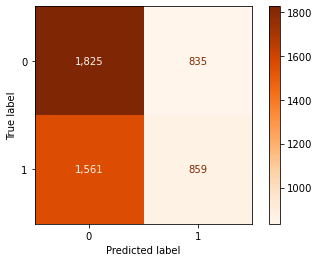

In [136]:
fn.evaluate(ada3, X_train_scaled3, X_test_scaled3, y_train3, y_test3)

### Random Forest Model with All Features

In [137]:
rf3 = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=0)
rf3.fit(X_train_scaled3, y_train3)
rf_preds3 = rf3.predict(X_test_scaled3) 

Train Scores
------------
Accuracy: 0.5708308722189407
Precision: 0.5842436700422624
F1 Score: 0.38412092957547495
ROC-AUC: 0.6018147562339754
--------------------
Test Scores
-----------
Accuracy: 0.5257874015748032
Precision: 0.5189793587582282
F1 Score: 0.3235046335299073
ROC-AUC: 0.536581199900578


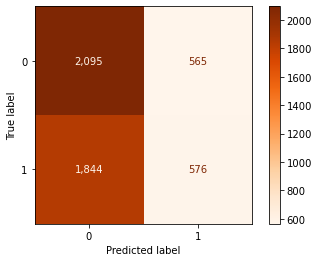

In [138]:
fn.evaluate(rf3, X_train_scaled3, X_test_scaled3, y_train3, y_test3)

### Feature Importances with All Features

The models are performing about the same with all features included. Since the random forest model seems to be performing the best (although only by about a percentage point), I'm going to use this model to try and select some of the most promising features from the set.

In [139]:
importances3 = rf3.feature_importances_

In [140]:
rf_importances3 = pd.DataFrame(index=X_test3.columns, data=importances3).sort_values(by=0,ascending=False)

In [141]:
rf_importances3

,0
FIPST,0.056268
Student_Teacher_Ratio,0.028777
State_Avg_Reading,0.026445
Per_Pupil_Support,0.026434
Total_Students,0.025310
Per_Pupil_Support_Staff,0.023652
Percent_Taxes,0.022189
Zip_Population,0.020628
Per_Pupil_Spending,0.020578
Per_Pupil_Salaries,0.020380


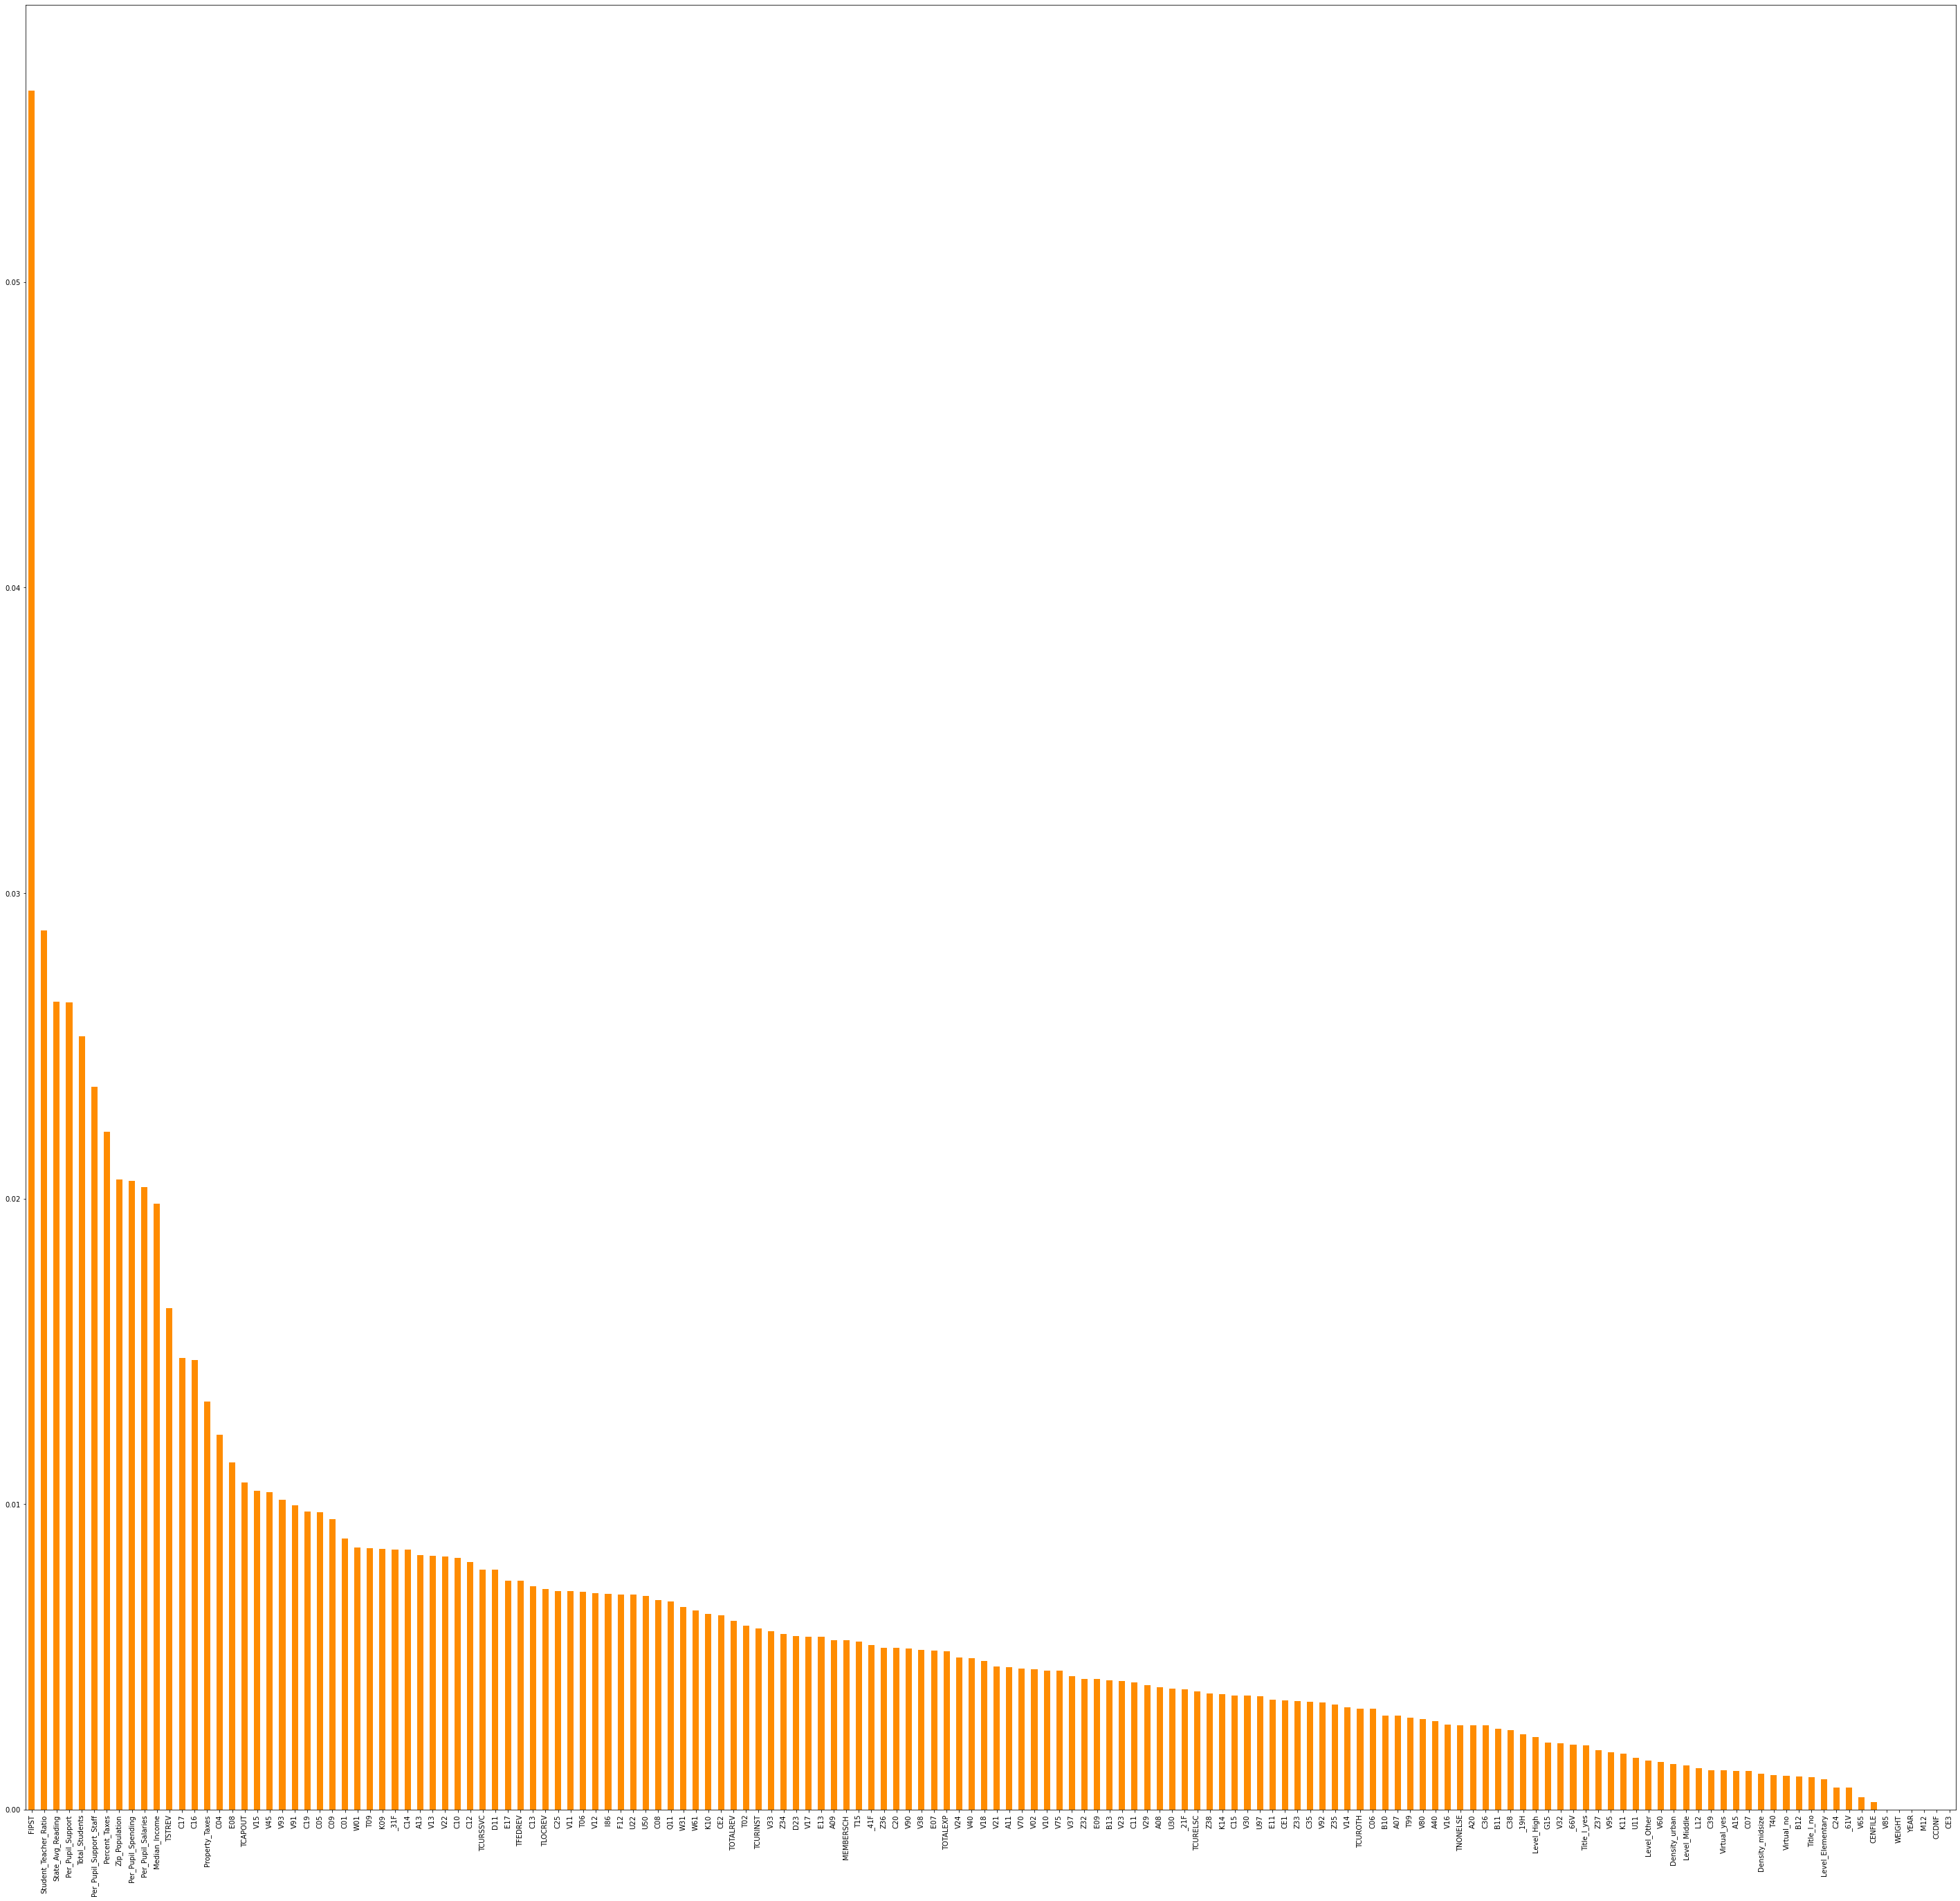

In [142]:
# plot feature importance
rf_importances3.plot(kind='bar', legend=False, color='darkorange', figsize=(50,48));

In [143]:
imp_features2 = rf_importances3.loc[rf_importances3[0] > 0.01]

In [144]:
imp_features2 = imp_features2.transpose()

In [145]:
imp_features2

,FIPST,Student_Teacher_Ratio,State_Avg_Reading,Per_Pupil_Support,Total_Students,Per_Pupil_Support_Staff,Percent_Taxes,Zip_Population,Per_Pupil_Spending,Per_Pupil_Salaries,Median_Income,TSTREV,C17,C16,Property_Taxes,C04,E08,TCAPOUT,V15,V45,V93
0,0.056268,0.028777,0.026445,0.026434,0.02531,0.023652,0.022189,0.020628,0.020578,0.02038,0.019841,0.016411,0.014789,0.014715,0.013358,0.012269,0.011377,0.010718,0.01045,0.0104,0.010155


In [146]:
importants_list = imp_features2.columns.values.tolist()

In [147]:
importants_list

['FIPST',
 'Student_Teacher_Ratio',
 'State_Avg_Reading',
 'Per_Pupil_Support',
 'Total_Students',
 'Per_Pupil_Support_Staff',
 'Percent_Taxes',
 'Zip_Population',
 'Per_Pupil_Spending',
 'Per_Pupil_Salaries',
 'Median_Income',
 'TSTREV',
 'C17',
 'C16',
 'Property_Taxes',
 'C04',
 'E08',
 'TCAPOUT',
 'V15',
 'V45',
 'V93']

In [148]:
df4 = df3[[c for c in df3.columns if c in importants_list]]

In [149]:
df4.head()

,Zip_Population,Median_Income,Property_Taxes,Percent_Taxes,Per_Pupil_Spending,Per_Pupil_Support,Per_Pupil_Support_Staff,Per_Pupil_Salaries,Total_Students,Student_Teacher_Ratio,FIPST,C16,C17,TSTREV,C04,E08,V45,TCAPOUT,V15,V93
0,63864,41566,7637,8.7,8600,512,241,3357,206,11.31,37,4000,0,1506000,0,9000,21000,18000,0,0
1,63864,41566,2411346,24.4,15793,969,1189,5023,439,11.31,37,1305000,0,213378000,0,4900000,18478000,24800000,3019000,422000
2,63864,41566,15097,18.2,12453,588,825,4813,363,11.86,37,1305000,0,213378000,0,4900000,18478000,24800000,3019000,422000
3,63864,41566,0,46.0,14732,786,738,5595,1869,16.78,37,1305000,0,213378000,0,4900000,18478000,24800000,3019000,422000
4,63864,41566,0,0.0,0,0,0,0,339,10.59,37,1305000,0,213378000,0,4900000,18478000,24800000,3019000,422000


In [150]:
df4.shape

(25396, 20)

In [151]:
#Train-test split for final model
X_train4, X_test4, y_train4, y_test4 = train_test_split(df4, target3, test_size=0.20, random_state=42)

In [152]:
scaler = StandardScaler()
# Train our scaler on training data, then fit to testing
X_train_scaled4 = scaler.fit_transform(X_train4, y=None)
X_test_scaled4 = scaler.transform(X_test4)

### Random Forest with Selected Features

In [153]:
rf4 = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=0)
rf4.fit(X_train_scaled4, y_train4)
rf_preds4 = rf4.predict(X_test_scaled4) 

Train Scores
------------
Accuracy: 0.7363162039771609
Precision: 0.7365026968295598
F1 Score: 0.7148863696843898
ROC-AUC: 0.8107289572588534
--------------------
Test Scores
-----------
Accuracy: 0.7395669291338582
Precision: 0.7396582667507198
F1 Score: 0.7180907734924356
ROC-AUC: 0.8113039054247189


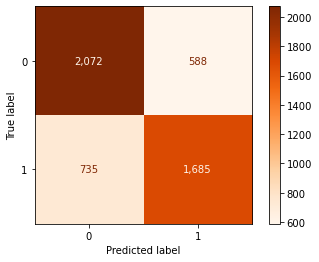

In [154]:
fn.evaluate(rf4, X_train_scaled4, X_test_scaled4, y_train4, y_test4)

### AdaBoost with Selected Features

In [155]:
ada4 = AdaBoostClassifier()
ada4.fit(X_train_scaled4, y_train4)

AdaBoostClassifier()

Train Scores
------------
Accuracy: 0.7350856467808624
Precision: 0.734957104924134
F1 Score: 0.7178653805829315
ROC-AUC: 0.8122313067208728
--------------------
Test Scores
-----------
Accuracy: 0.7362204724409449
Precision: 0.7361168244897843
F1 Score: 0.716821639898563
ROC-AUC: 0.8139214254644876


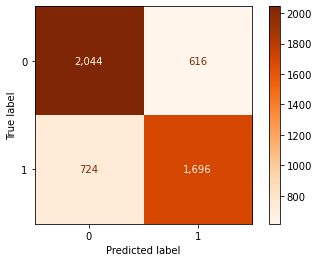

In [156]:
fn.evaluate(ada4, X_train_scaled4, X_test_scaled4, y_train4, y_test4)

In [157]:
final_model = df4.rename({'FIPST':'County','C16':'Fed$_SchoolSafety','C19':'Fed$_CTE','TSTREV':'Total_State_Revenue','C04':'State$_StaffImprove','E08':'Superint_Expenditures','TCAPOUT':'Capital_Outlay','K09':'$_Equipment','V15':'Superint_Salaries','C17':'$_SchoolSafety'}, axis=1
                         )

In [158]:
final_model.head()

,Zip_Population,Median_Income,Property_Taxes,Percent_Taxes,Per_Pupil_Spending,Per_Pupil_Support,Per_Pupil_Support_Staff,Per_Pupil_Salaries,Total_Students,Student_Teacher_Ratio,County,Fed$_SchoolSafety,$_SchoolSafety,Total_State_Revenue,State$_StaffImprove,Superint_Expenditures,V45,Capital_Outlay,Superint_Salaries,V93
0,63864,41566,7637,8.7,8600,512,241,3357,206,11.31,37,4000,0,1506000,0,9000,21000,18000,0,0
1,63864,41566,2411346,24.4,15793,969,1189,5023,439,11.31,37,1305000,0,213378000,0,4900000,18478000,24800000,3019000,422000
2,63864,41566,15097,18.2,12453,588,825,4813,363,11.86,37,1305000,0,213378000,0,4900000,18478000,24800000,3019000,422000
3,63864,41566,0,46.0,14732,786,738,5595,1869,16.78,37,1305000,0,213378000,0,4900000,18478000,24800000,3019000,422000
4,63864,41566,0,0.0,0,0,0,0,339,10.59,37,1305000,0,213378000,0,4900000,18478000,24800000,3019000,422000


### Importances from Final Model

In [159]:
final_importances = rf4.feature_importances_

In [160]:
rf_importances4 = pd.DataFrame(index=final_model.columns, data=final_importances).sort_values(by=0,ascending=False)

In [161]:
rf_importances4

,0
Median_Income,0.327882
County,0.117668
Student_Teacher_Ratio,0.114430
V93,0.083880
Superint_Salaries,0.069805
Total_State_Revenue,0.054030
Superint_Expenditures,0.036486
V45,0.034505
$_SchoolSafety,0.033478
Capital_Outlay,0.032779


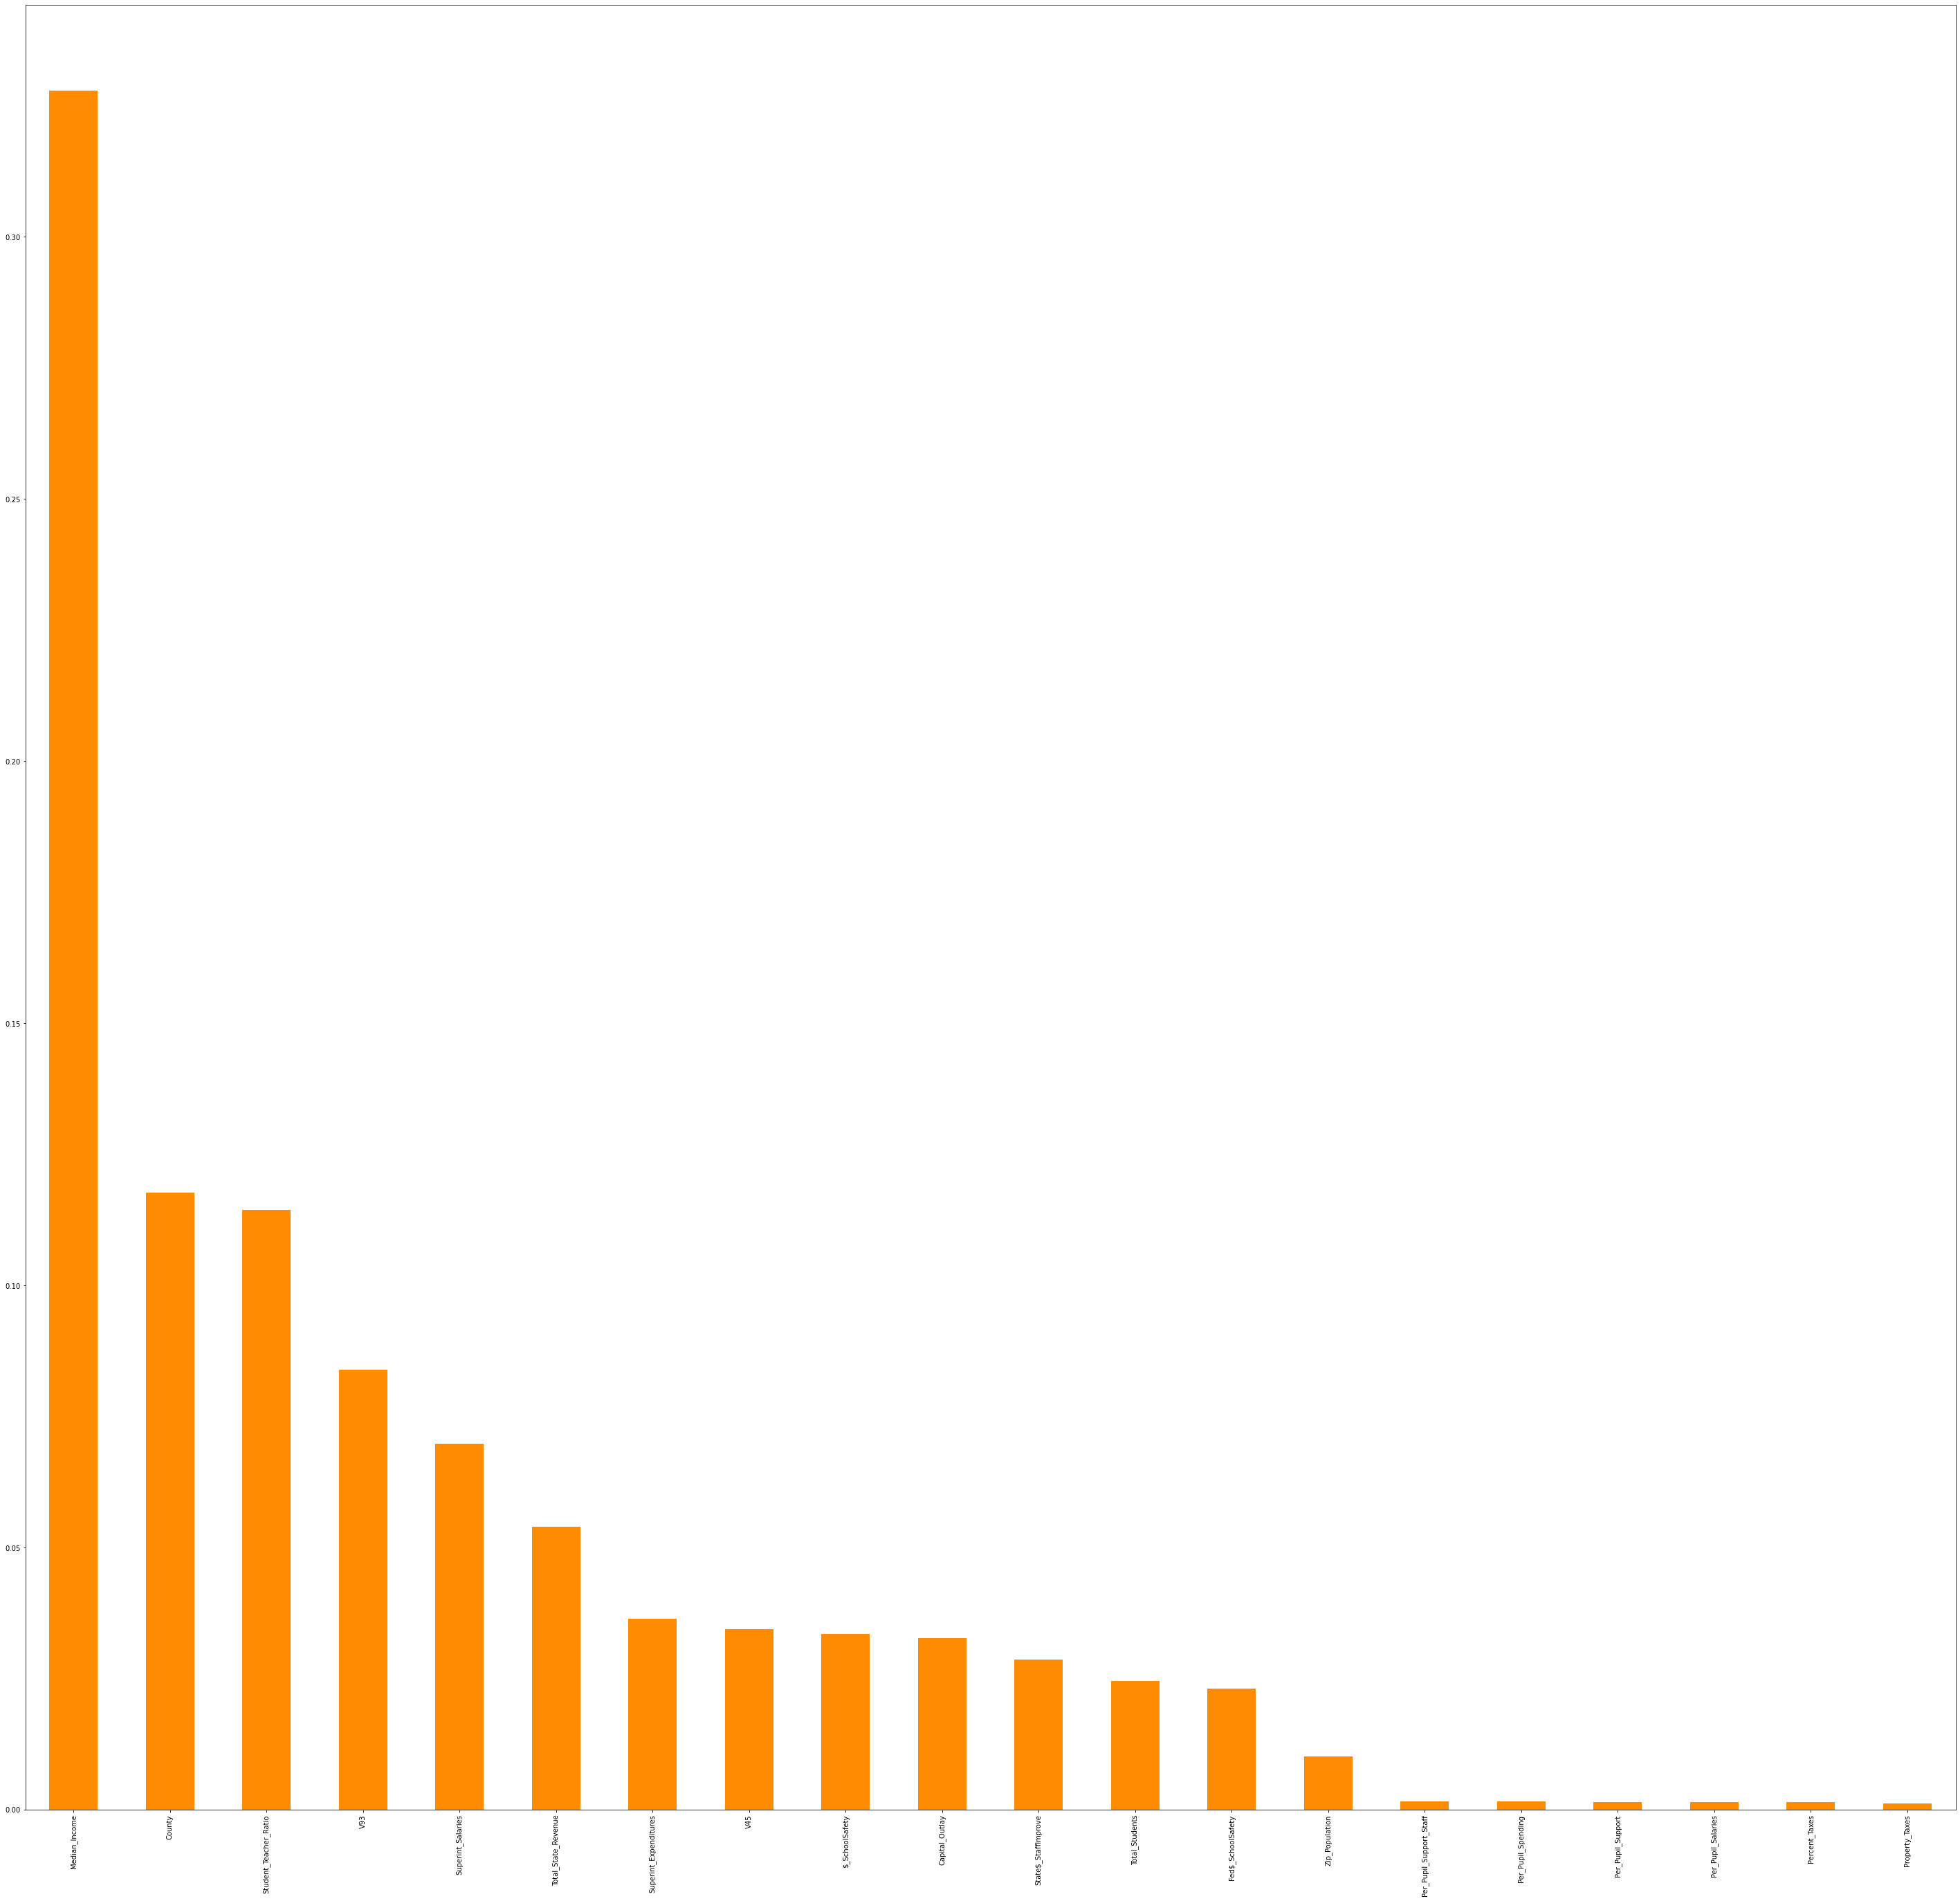

In [162]:
# plot feature importance
rf_importances4.plot(kind='bar', legend=False, color='darkorange', figsize=(50,48));
pl.savefig('Final Feature Importances')

In [163]:
#Plot just 10 top importances
top10_features = rf_importances4.loc[rf_importances4[0] >.04]

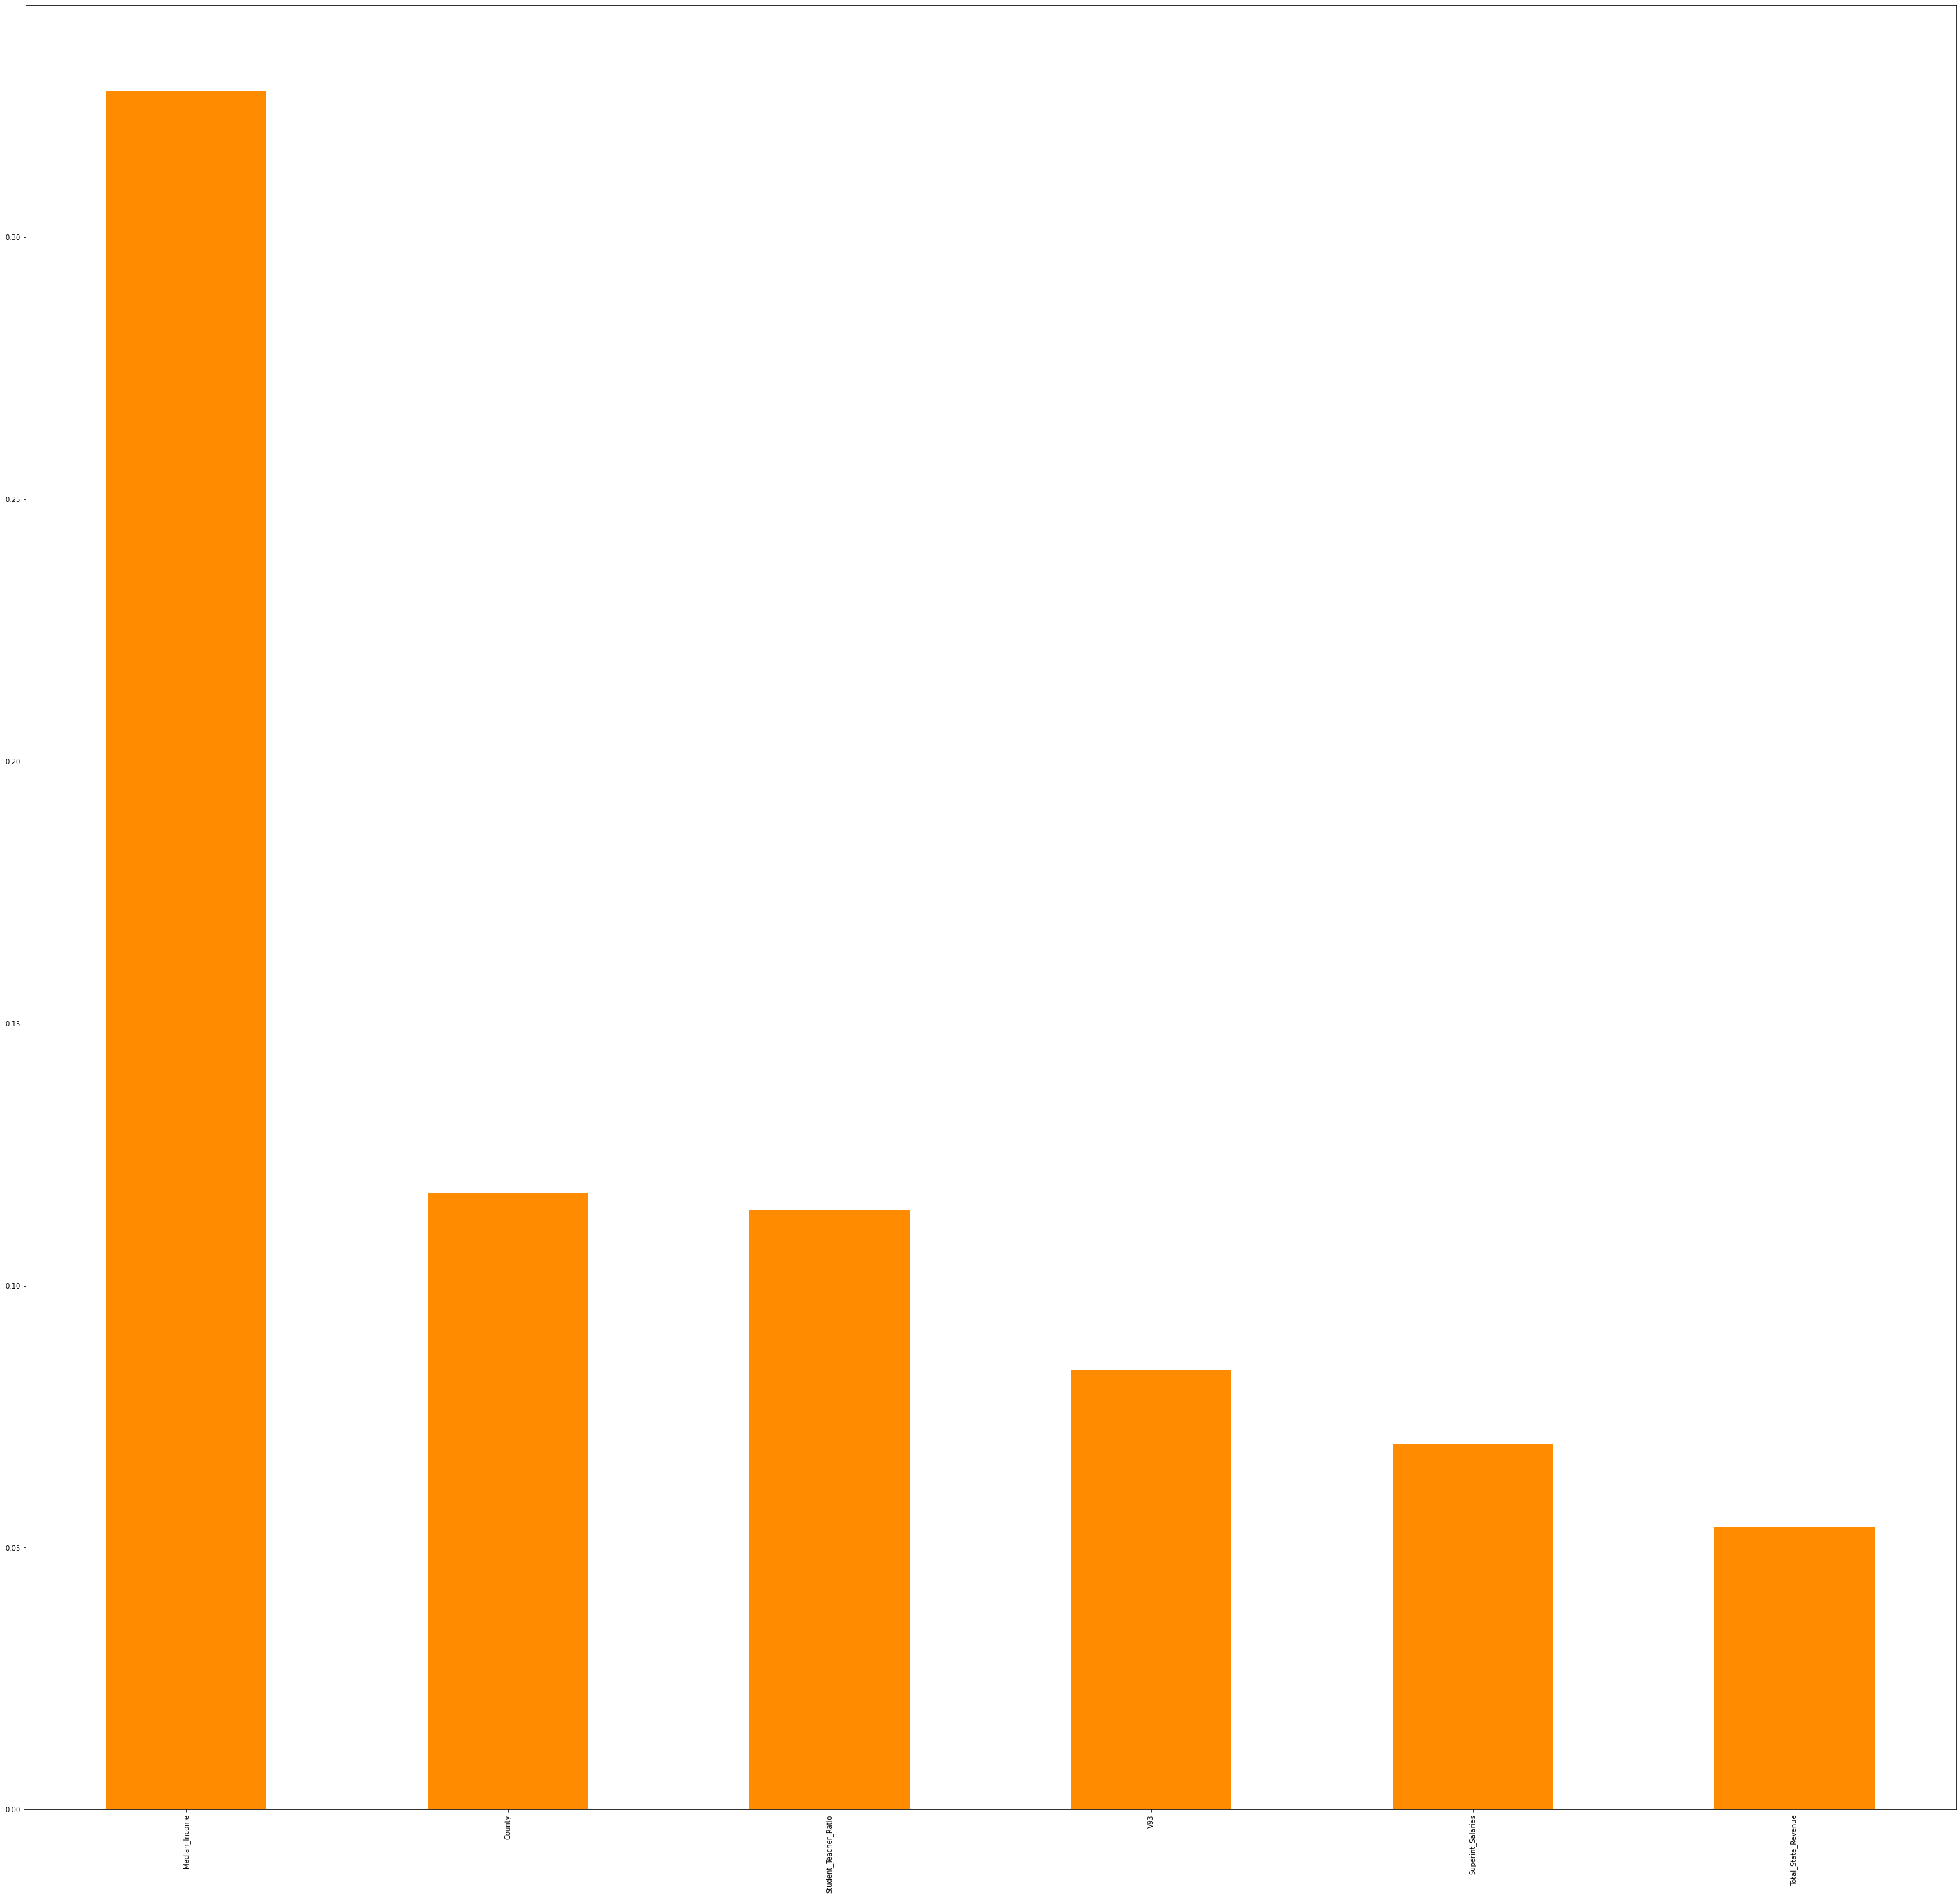

In [164]:
top10_features.plot(kind='bar', legend=False, color='darkorange', figsize=(50,48));
pl.savefig('Top 10 Feature Importances')